# Background Information

When an analyst estimates the price of a house, they need to consider many predictors, including its location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict house prices. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# Import Libraries and Data

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Model evaluation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

In [278]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv('ames_houses_data.csv', index_col="Order")
X = houses_data.drop(columns=["price"])
y = houses_data.loc[:, "price"]
print("X size: ", X.shape)

X size:  (2930, 81)


For simplicity, I only used countinuous, discrete, and ordinal predictors to train my models. Hence, I removed all of the nominal predictors from the dataset.

In [279]:
X = X.select_dtypes(include="number")

# Manually remove nominal columns encoded with integers
X.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True) 

print("X size after removing unwanted predictors: ", X.shape)

X size after removing unwanted predictors:  (2930, 34)


I then split the dataset into a training set (80%) and a test set (20%). 

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)

X_train size:  (2344, 34)
X_test size:  (586, 34)


# Exploratory Data Analysis

## Distributions of the variables

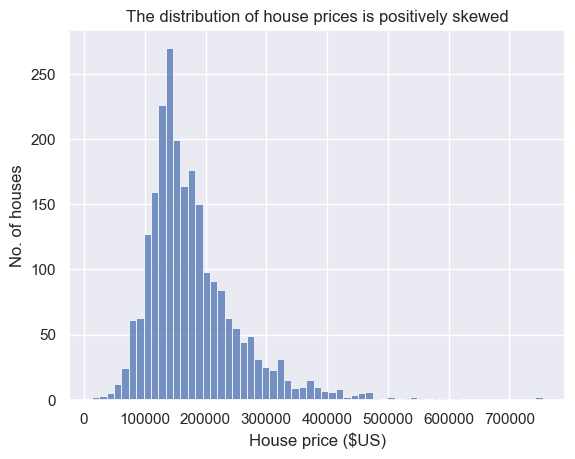

In [281]:
# Distribution of house prices (the target)
sns.histplot(y_train)
plt.title("The distribution of house prices is positively skewed")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.show()

The distribution of house prices is positively skewed due to a few very expensive houses.

In [282]:
# Distributions of the predictors. Commented out since it takes a while to run.
# X_train.hist(figsize=(15, 17))
# plt.show()

![](predictor_histograms.png)

Many of the predictors (Pool.Area, Screen.Porch) are 0 for most of the houses. For example:
- **Pool.Area**: Pool area 
- **Screen.Porch**: Screen porch area

This is because most houses do not have these amenities.

## Correlations between variables

Due to the large number of predictors, a correlation heatmap would be hard to read. Hence, I did not include one.

In [283]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

### Correlations with the target (house price)

In [284]:
most_positive = correlation_matrix.loc["price"].sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.loc["price"].sort_values(ascending=True)[0:1]
print(f"The predictor that was most negatively correlated with house price was:\n", 
       most_negative, sep="")

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.795298
area             0.698315
Garage.Cars      0.644304
Garage.Area      0.633106
Total.Bsmt.SF    0.612256
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.130722
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage. (Notice that is is highly correlated with GarageCars). 

There were no quantitative predictors that were significantly negatively correlated with the house price.

### Correlations between predictors

In [285]:
most_positive = correlation_matrix.stack().sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictor pairs that were most positively correlated were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.stack().sort_values(ascending=True)[0:1]
print(f"The predictor pair that was most negatively correlated was:\n", 
       most_negative, sep="")

The 5 predictor pairs that were most positively correlated were:
Garage.Area    Garage.Cars      0.883871
Garage.Yr.Blt  Year.Built       0.824690
X1st.Flr.SF    Total.Bsmt.SF    0.813946
TotRms.AbvGrd  area             0.806434
price          Overall.Qual     0.795298
dtype: float64

The predictor pair that was most negatively correlated was:
Bsmt.Unf.SF  BsmtFin.SF.1   -0.47883
dtype: float64


# Training Set Procesesing

Each step in the data processing can be represented by a scikit-learn transformer object. These transfromers can be assembled into a Pipeline object, which can be used to apply all of the data processing steps to new data in one method call.

## Data Standardization

I will use scikit-learn's StandardScaler transformer to standardize each predictor variable to a mean of 0 and a standard deviation of 1. This will improve the training speed and performance of the regression models.

## Handling missing data

Regression models cannot be trained on data with missing values. The simplest solution is to delete data points with missing values. But data points with a few missing predictor values still have a lot of information in their other predictor values. So a better option is to replace missing data with a best guess based on other data in the dataset (data imputation). 

I will use scikit-learn's KNNImputer transformer to impute missing data. For each data point with missing predictor values, k-Nearest Neighbors:
1. Identifies the k data points that are closest to it in the predictor space.
2. Takes the averages of their predictor values and uses them to impute the missing values.  

## Data Processing Pipeline

In [286]:
data_processing = make_pipeline(StandardScaler(), KNNImputer())

## Removing High-Leverage Points

High-leverage points are far away from other data points in the predictor space. They can worsen the fit on the rest of the data points. I will use scikit-learn's LocalOutlierFactor estimator to identify high leverage points, then I will remove them. Technically, this should be a step in the data processing pipeline, but I do not know how to do that. 

Furthermore, if the model is asked to predict the price of a house that is a high-leverage point, it should not return a prediction, as it was not trained on similar houses.

In [287]:
local_outlier = make_pipeline(data_processing, LocalOutlierFactor()) 
pred_outlier_train = local_outlier.fit_predict(X_train)

not_an_outlier = (pred_outlier_train == 1)
X_train = X_train[not_an_outlier]
y_train = y_train[not_an_outlier]

# Linear Regresssion

One of the simplest models we can use to predict the house prices is multiple linear regression. I will now train a multiple linear regression model on the entire training set then fit it on the training set to obtain a residual plot.

In [288]:
linear_regression = make_pipeline(data_processing, LinearRegression()) 
linear_train = linear_regression.fit(X_train, y_train)
pred_y_train = pd.Series(linear_train.predict(X_train), 
                         index=X_train.index)
train_residuals = y_train - pred_y_train

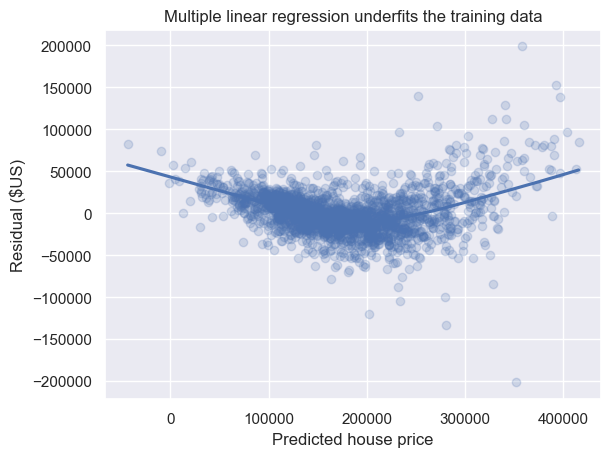

In [289]:
sns.regplot(x=pred_y_train, y=train_residuals, 
            scatter_kws={"alpha": 0.2},
            lowess=True) #locally weighted linear regression 

plt.title("Multiple linear regression underfits the training data")
plt.xlabel("Predicted house price")
plt.ylabel("Residual ($US)")
plt.show()

The residual plot is curved, which suggests that linear regression underfits the training data.

Since the test set is reserved for the evaluation of our final model, I will use cross-validation to evaluate the multiple linear regression model. Since I will be evaluating multiple regression models, I will create a function to calculate the regression scores for each.

In [290]:
def regression_scores(regression_pipeline):
    reg_scores = cross_validate(regression_pipeline, 
                                X_train, y_train, 
                                scoring="r2",
                                return_train_score=True,
                                return_estimator=True)
    print("Mean R2 score on training sets: %0.2f (%0.2f SD)" % 
         (reg_scores["train_score"].mean(), reg_scores["train_score"].std()))
    print("Mean R2 score on validation sets: %0.2f (%0.2f SD)" % 
         (reg_scores["test_score"].mean(), reg_scores["test_score"].std()))  

In [291]:
regression_scores(linear_regression)

Mean R2 score on training sets: 0.87 (0.00 SD)
Mean R2 score on validation sets: 0.87 (0.01 SD)


In other words, 87% of the variation in the validation set house prices is explained by the linear regression model. The R2 score on the training sets and validation sets are very similar, suggesting the model may be underfitting.

# Polynomial Regression

To increase model complexity, I will add second-order predictors that are powers and products of the original predictors.

In [292]:
quadratic_regression = \
make_pipeline(data_processing, 
              PolynomialFeatures(degree=2),
              LinearRegression())

In [293]:
quadratic_train = quadratic_regression.fit(X_train, y_train)
quadratic_model = quadratic_train.named_steps["linearregression"]
num_coef = len(quadratic_model.coef_[quadratic_model.coef_ != 0])
print("Number of coefficients: %i" % num_coef)

Number of coefficients: 614


This is a lot of predictors compared to the number of data points (around 2000), so we expect the model to overfit.

In [294]:
regression_scores(quadratic_regression)

Mean R2 score on training sets: 0.95 (0.00 SD)
Mean R2 score on validation sets: -1322086071841991688192.00 (1830808602440061943808.00 SD)


Since the R2 score is much higher for the training sets than the validation sets (The more negative the score, the worse the fit), the model is overfitting.

# Lasso Regression

Lasso regression restricts the magnitudes of the regression coefficients to prevent overfitting. It can also set coefficients to 0, effectively removing predictors from the model. The amount of restriction is controlled by a hyperparameter ($\alpha$). 

To find a good value for $\alpha$, we will use GridSearchCV() to train and evaluate models with different $\alpha$ values. (I started with a very wide search range (0.1 - 100_000) then narrowed it down.)

In [295]:
param_grid = {'alpha': [460, 470, 480, 490, 500]}
lasso_search = make_pipeline(data_processing,
                             PolynomialFeatures(degree=2),
                             GridSearchCV(Lasso(), param_grid, cv=5)) 

lasso_search_train = lasso_search.fit(X_train, y_train)
lasso_search_model = lasso_search_train.named_steps["gridsearchcv"]
best_alpha = lasso_search_model.best_params_["alpha"]
print("Best alpha value: %i" % best_alpha)

Best alpha value: 490


In [296]:
lasso_regression = make_pipeline(data_processing, 
                                 PolynomialFeatures(degree=2),
                                 Lasso(alpha=best_alpha)) 

In [297]:
lasso_train = lasso_regression.fit(X_train, y_train)
lasso_model = lasso_train.named_steps["lasso"]
num_coef = len(lasso_model.coef_[lasso_model.coef_ != 0])
print("Number of coefficients: %i" % num_coef)

Number of coefficients: 139


Lasso regression removed 78% of the predictors in the quadratic regression.

In [298]:
regression_scores(lasso_regression)

Mean R2 score on training sets: 0.93 (0.00 SD)
Mean R2 score on validation sets: 0.91 (0.01 SD)


The R2 score on the validation set (0.91) is the highest out of all the models tested so far, indicating that this is the best model so far.

# Final Model Evaluation

I will now train the quadratic lasso model using the entire training set and evaluate it using the test set. Hopefully, the R2 score will increase since the model now has more data to use for training. 

In [299]:
pred_y_test = pd.Series(lasso_train.predict(X_test), 
                        index=X_test.index)

print("Test set R2 score: %0.2f" % r2_score(y_test, pred_y_test))

Test set R2 score: 0.86


Unfortunately, the test set score is significantly lower than the average validation set score (0.91). This could be due to outliers in the test set which the data processing pipeline did not remove because I could not figure out how to add outlier removal as a pipeline step.